### Imports

In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.transforms import v2

import os
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import numpy as np

import json
from tqdm import tqdm
from PIL import Image

plt.style.use('dark_background')

### Сохранение и загрузка модели

In [ ]:
# сохранение моделей, тензоров и словарей
torch.save(obj, PATH)

# загрузка моделей, тензоров и словарей
torch.load(PATH)

In [23]:
dict_1 = {'key_1':torch.tensor([1,2,3]), 'key_2':torch.tensor([2,3,4])}
dict_1

{'key_1': tensor([1, 2, 3]), 'key_2': tensor([2, 3, 4])}

In [24]:
# сохраним созданный словарь в формате торча
torch.save(dict_1, 'dict_1.pt')

In [25]:
# загрузим сохраненный словарь
new_dict = torch.load('dict_1.pt')
new_dict

/tmp/ipykernel_9910/2449913479.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_dict = torch.load('dict_1.pt')


{'key_1': tensor([1, 2, 3]), 'key_2': tensor([2, 3, 4])}

### Задача регрессии

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
class DatasetReg(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.list_name_file = os.listdir(path)
        if 'coords.json' in self.list_name_file:
            self.list_name_file.remove('coords.json')

        self.len_dataset = len(self.list_name_file)

        with open(os.path.join(self.path, 'coords.json'), 'r') as f:
            self.dict_coords = json.load(f)

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, index):
        name_file = self.list_name_file[index]
        path_img = os.path.join(self.path, name_file)

        img = Image.open(path_img)
        coord = self.dict_coords[name_file]

        if self.transform:
            img = self.transform(img)
            coord = torch.tensor(coord, dtype=torch.float32)


        return img, coord

In [4]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5, ), std=(0.5, ))
    ]
)

In [5]:
dataset = DatasetReg(path='dataset', transform=transform)

Coord = tensor([28., 31.])


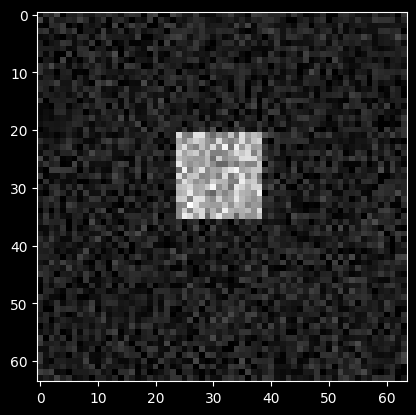

In [6]:
img, coord = dataset[2512]

print(f'Coord = {coord}')
plt.imshow(img.numpy()[0], cmap='gray')

In [7]:
train_set, val_set, test_set = random_split(dataset, [0.7, 0.1, 0.2])

In [8]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

In [9]:
class MyModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 128)
        self.layer_2 = nn.Linear(128, output)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        out = self.layer_2(x)
        return out

In [32]:
# создаем и отправляем на cuda
model = MyModel(64*64, 2).to(device)

In [33]:
# Проверяем правильность построения модели
input = torch.rand([16, 64*64], dtype=torch.float32).to(device)

out = model(input)
out.shape    # (16,2)

torch.Size([16, 2])

In [34]:
# выбираем функцию потерь и оптимизатор градиентного спуска
loss_model = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
                                                          mode='min',
                                                          factor=0.1,
                                                          patience=5)

In [35]:
EPOCHS = 20
train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr_list = []
best_loss = None
threshold = 0.25

In [36]:
# Цикл обучения
for epoch in range(EPOCHS):

    # 1. Тренировка модели
    model.train()
    running_train_loss = []
    true_answer = 0
    # добавим трейн луп, чтобы видеть прогресс обучения модели
    train_loop = tqdm(train_loader, leave=False)
    for x, targets in train_loop:
        # - Данные
        # (batch.size, 1, 64, 64) --> (batch.size, 64*64)
        x = x.reshape(-1, 64*64).to(device)
        targets = targets.to(device)

        # - Прямой проход + расчет ошибки модели
        pred = model(x)
        loss = loss_model(pred, targets)

        # - Обратный проход
        opt.zero_grad()
        loss.backward()
        # - Шаг оптимизации
        opt.step()

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)

        true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()

        train_loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}")


    # 2. Расчет значения метрики
    running_train_acc = true_answer / len(train_set)

    # 3. Сохранение значения функции потерь и метрики
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)

    # 4. Проверка модели (Валидация)
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answer = 0
        for x, targets in val_loader:
            # - Данные
            # (batch.size, 1, 64, 64) --> (batch.size, 64*64)
            x = x.reshape(-1, 64*64).to(device)
            targets = targets.to(device)

            # - Прямой проход + расчет ошибки модели
            pred = model(x)
            loss = loss_model(pred, targets)

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)

            true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()

        # 2. Расчет значения метрики
        running_val_acc = true_answer / len(val_set)

        # 3. Сохранение значения функции потерь и метрики    true_answer = 0

        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)

    lr_scheduler.step(mean_val_loss)
    lr = lr_scheduler._last_lr[0]
    lr_list.append(lr)

    print(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}, train_acc={running_train_acc:.4f}, val_loss={mean_val_loss:.4f}, val_acc={running_val_acc:.4f}, lr={lr:.4f}")

    # добавляем две проверки, для сохранения лучшей модели
    if best_loss is None:
        best_loss = mean_val_loss
    # это самое простое условие, но это неприемлемо
    # if mean_val_loss < best_loss:
    #     best_loss = mean_val_loss
    # мы будем сохранять модель, чей лосс улучшился на ЗНАЧИМОЕ для нас значение
    if mean_val_loss < best_loss - best_loss*threshold:
        best_loss = mean_val_loss

        torch.save(model.state_dict(), f'model_state_dict_epoch_{epoch+1}.pt')
        print(f"На эпохе: {epoch+1}, сохранена модель со значением функции потерь на валидаци: {mean_val_loss:.4f}", end='\n\n')

Epoch [1/20], train_loss=1.7556, train_acc=0.6347, val_loss=0.3779, val_acc=0.1776, lr=0.0010


Epoch [2/20], train_loss=0.1378, train_acc=0.6828, val_loss=0.0691, val_acc=0.8913, lr=0.0010
На эпохе: 2, сохранена модель со значением функции потерь на валидаци: 0.0691



Epoch [3/20], train_loss=0.1164, train_acc=0.7400, val_loss=0.0880, val_acc=0.8366, lr=0.0010


Epoch [4/20], train_loss=0.0986, train_acc=0.7981, val_loss=0.1529, val_acc=0.6183, lr=0.0010


Epoch [5/20], train_loss=0.0850, train_acc=0.8429, val_loss=0.1480, val_acc=0.6470, lr=0.0010


Epoch [6/20], train_loss=0.0767, train_acc=0.8685, val_loss=0.0429, val_acc=0.9651, lr=0.0010
На эпохе: 6, сохранена модель со значением функции потерь на валидаци: 0.0429



Epoch [7/20], train_loss=0.0732, train_acc=0.8799, val_loss=0.0489, val_acc=0.9535, lr=0.0010


Epoch [8/20], train_loss=0.0690, train_acc=0.8942, val_loss=0.1100, val_acc=0.7615, lr=0.0010


Epoch [9/20], train_loss=0.0665, train_acc=0.8995, val_loss=0.1452, val_acc=0.6512, lr=0.0010


Epoch [10/20], train_loss=0.0627, train_acc=0.9104, val_loss=0.1193, val_acc=0.7500, lr=0.0010


Epoch [11/20], train_loss=0.0586, train_acc=0.9231, val_loss=0.0387, val_acc=0.9726, lr=0.0010


Epoch [12/20], train_loss=0.0578, train_acc=0.9267, val_loss=0.0472, val_acc=0.9615, lr=0.0010


Epoch [13/20], train_loss=0.0564, train_acc=0.9290, val_loss=0.0413, val_acc=0.9678, lr=0.0010


Epoch [14/20], train_loss=0.0539, train_acc=0.9363, val_loss=0.0767, val_acc=0.8708, lr=0.0010


Epoch [15/20], train_loss=0.0563, train_acc=0.9291, val_loss=0.0619, val_acc=0.9124, lr=0.0010


Epoch [16/20], train_loss=0.0546, train_acc=0.9344, val_loss=0.0981, val_acc=0.8020, lr=0.0010


Epoch [17/20], train_loss=0.0545, train_acc=0.9352, val_loss=0.0539, val_acc=0.9378, lr=0.0001


Epoch [18/20], train_loss=0.0303, train_acc=0.9895, val_loss=0.0352, val_acc=0.9809, lr=0.0001


Epoch [19/20], train_loss=0.0306, train_acc=0.9894, val_loss=0.0345, val_acc=0.9809, lr=0.0001


Epoch [20/20], train_loss=0.0305, train_acc=0.9891, val_loss=0.0358, val_acc=0.9794, lr=0.0001


val_loss = 0.0429, val_acc = 0.9651

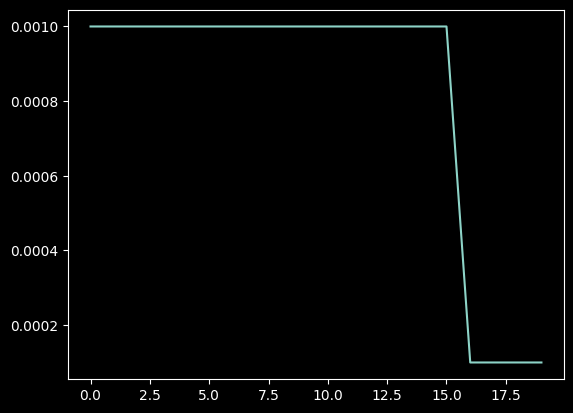

In [37]:
plt.plot(lr_list)
plt.show()

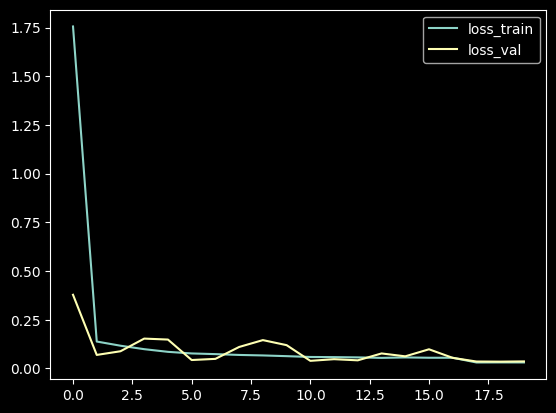

In [38]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()

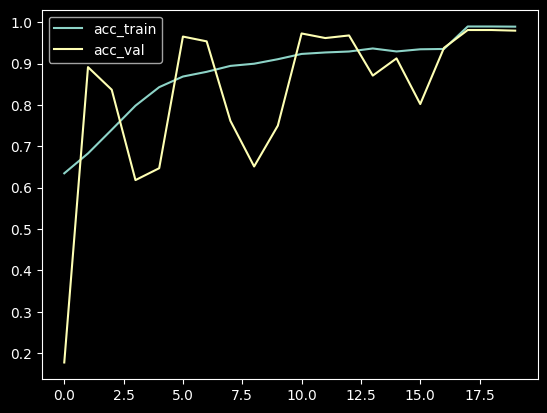

In [39]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['acc_train', 'acc_val'])
plt.show()

### Загрузка сохраненной модели

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [41]:
# загрузка параметров модели
param_model = torch.load('model_state_dict_epoch_6.pt')
param_model

/tmp/ipykernel_9910/2886747407.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  param_model = torch.load('model_state_dict_epoch_6.pt')


OrderedDict([('layer_1.weight',
              tensor([[ 0.0240,  0.0192,  0.0182,  ...,  0.0087,  0.0230,  0.0262],
                      [ 0.0056, -0.0334, -0.0120,  ...,  0.0070, -0.0136, -0.0029],
                      [ 0.0145, -0.0094,  0.0012,  ...,  0.0116, -0.0091, -0.0081],
                      ...,
                      [ 0.0422,  0.0394,  0.0195,  ...,  0.0141,  0.0301,  0.0348],
                      [ 0.0382,  0.0199,  0.0279,  ...,  0.0282,  0.0250,  0.0335],
                      [-0.0038, -0.0188, -0.0107,  ..., -0.0056, -0.0300,  0.0001]],
                     device='cuda:0')),
             ('layer_1.bias',
              tensor([-1.4907e-02,  7.9568e-03,  2.1328e-02, -1.1968e-02,  9.4071e-04,
                      -1.6254e-02,  1.9897e-02,  6.6543e-03, -1.2949e-02,  6.3609e-03,
                      -2.8500e-02, -9.8291e-03, -1.7069e-02, -3.4238e-03,  6.6955e-03,
                       1.4439e-02, -1.0026e-02, -1.2440e-02,  4.6242e-02, -8.8028e-03,
                  

In [42]:
# создание новой модели
new_model = MyModel(64*64, 2).to(device)

In [43]:
# Заменяем параметры модели на сохраненные
new_model.load_state_dict(param_model)

<All keys matched successfully>

In [45]:
# проверим новую модель на валидационных данных
new_model.eval()
with torch.no_grad():
    running_val_loss = []
    true_answer = 0
    for x, targets in val_loader:
        # Данные
        x = x.reshape(-1, 64*64).to(device)
        targets = targets.to(device)

        # прямой проход , расчет ошибки модели
        pred = new_model(x)
        loss = loss_model(pred, targets)

        running_val_loss.append(loss.item())
        mean_val_loss = sum(running_val_loss)/len(running_val_loss)

        true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()

    # Расчет значения метрики
    running_val_acc = true_answer / len(val_set)

print(f'val_loss = {mean_val_loss:.4f}, val_acc = {running_val_acc:.4f}')

val_loss = 0.0429, val_acc = 0.9651


### Сохранение модели и всех параметров для возможности ее дообучения

In [62]:
str_info = '''
class MyModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 128)
        self.layer_2 = nn.Linear(128, output)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        out = self.layer_2(x)
        return out
'''

EPOCHS = 30
save_epoch = 20
best_loss = None

In [68]:
checkpoint = {
    'info': str_info,
    'state_model': model.state_dict(),
    'state_opt': opt.state_dict(),
    'state_lr_scheduler': lr_scheduler.state_dict(),
    'loss':{
        'train_loss': train_loss,
        'val_loss': val_loss,
        'best_loss': best_loss
    },
    'metric':{
        'train_acc': train_acc,
        'val_acc': val_acc
    },
    'lr': lr_list,
    'epoch':{
        'EPOCHS': EPOCHS,
        'save_epoch': save_epoch
    },
    'threshold': threshold,
}

torch.save(checkpoint, 'model_state_dict_09_12_24')

In [69]:
load_model_state = torch.load('model_state_dict_09_12_24')

/tmp/ipykernel_9910/1754070027.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model_state = torch.load('model_state_dict_09_12_24')


In [70]:
print(load_model_state['state_lr_scheduler'])

{'factor': 0.1, 'min_lrs': [0], 'patience': 5, 'verbose': False, 'cooldown': 0, 'cooldown_counter': 0, 'mode': 'min', 'threshold': 0.0001, 'threshold_mode': 'rel', 'eps': 1e-08, 'last_epoch': 20, '_last_lr': [0.0001], 'mode_worse': inf, 'best': 0.03452729829102755, 'num_bad_epochs': 1}


In [71]:
# создаем еще одну новую модель
new_model_1 = MyModel(64*64, 2).to(device)
# обновляем все зи загруженного словаря
loss_model = nn.MSELoss()
new_opt = torch.optim.Adam(new_model_1.parameters(), lr=0.001)
new_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(new_opt)


In [73]:
# загрузим в новую модель состояние обученной модели
new_model_1.load_state_dict(load_model_state['state_model'])
# в новый оптимизатор состояние оптимизатора
new_opt.load_state_dict(load_model_state['state_opt'])
# в новый шедулер - состояние шедулера!)
new_lr_scheduler.load_state_dict(load_model_state['state_lr_scheduler'])

Выполним следующюю ячейку и продолжим обучение с 21ой эпохи

In [76]:
EPOCHS = load_model_state['epoch']['EPOCHS']
save_epoch = load_model_state['epoch']['save_epoch'] 


train_loss = load_model_state['loss']['train_loss'] 
train_acc = load_model_state['metric']['train_acc'] 
val_loss = load_model_state['loss']['val_loss'] 
val_acc = load_model_state['metric']['val_acc'] 
lr_list = load_model_state['lr']

best_loss = load_model_state['loss']['best_loss'] 
threshold = load_model_state['threshold']


# Цикл обучения
for epoch in range(save_epoch, EPOCHS):

    # 1. Тренировка модели
    new_model_1.train()
    running_train_loss = []
    true_answer = 0
    # добавим трейн луп, чтобы видеть прогресс обучения модели
    train_loop = tqdm(train_loader, leave=False)
    for x, targets in train_loop:
        # - Данные
        # (batch.size, 1, 64, 64) --> (batch.size, 64*64)
        x = x.reshape(-1, 64*64).to(device)
        targets = targets.to(device)

        # - Прямой проход + расчет ошибки модели
        pred = new_model_1(x)
        loss = loss_model(pred, targets)

        # - Обратный проход
        new_opt.zero_grad()
        loss.backward()
        # - Шаг оптимизации
        new_opt.step()

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)

        true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()

        train_loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}")


    # 2. Расчет значения метрики
    running_train_acc = true_answer / len(train_set)

    # 3. Сохранение значения функции потерь и метрики
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)

    # 4. Проверка модели (Валидация)
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answer = 0
        for x, targets in val_loader:
            # - Данные
            # (batch.size, 1, 64, 64) --> (batch.size, 64*64)
            x = x.reshape(-1, 64*64).to(device)
            targets = targets.to(device)

            # - Прямой проход + расчет ошибки модели
            pred = model(x)
            loss = loss_model(pred, targets)

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)

            true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()

        # 2. Расчет значения метрики
        running_val_acc = true_answer / len(val_set)

        # 3. Сохранение значения функции потерь и метрики    true_answer = 0

        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)

    new_lr_scheduler.step(mean_val_loss)
    lr = new_lr_scheduler._last_lr[0]
    lr_list.append(lr)

    print(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}, train_acc={running_train_acc:.4f}, val_loss={mean_val_loss:.4f}, val_acc={running_val_acc:.4f}, lr={lr:.4f}")

    # добавляем две проверки, для сохранения лучшей модели
    if best_loss is None:
        best_loss = mean_val_loss
    # это самое простое условие, но это неприемлемо
    # if mean_val_loss < best_loss:
    #     best_loss = mean_val_loss
    # мы будем сохранять модель, чей лосс улучшился на ЗНАЧИМОЕ для нас значение
    if mean_val_loss < best_loss - best_loss*threshold:
        best_loss = mean_val_loss
        
        # так же сохраняем словарь в случае улучшения модели
        checkpoint = {
            'info': str_info,
            'state_model': new_model_1.state_dict(),
            'state_opt': new_opt.state_dict(),
            'state_lr_scheduler': new_lr_scheduler.state_dict(),
            'loss':{
                'train_loss': train_loss,
                'val_loss': val_loss,
                'best_loss': best_loss
            },
            'metric':{
                'train_acc': train_acc,
                'val_acc': val_acc
            },
            'lr': lr_list,
            'epoch':{
                'EPOCHS': EPOCHS,
                'save_epoch': epoch
            },
            'threshold': threshold,
        }

        

        torch.save(model.state_dict(), f'model_state_dict_epoch_{epoch+1}.pt')
        print(f"На эпохе: {epoch+1}, сохранена модель со значением функции потерь на валидаци: {mean_val_loss:.4f}", end='\n\n')

Epoch [21/30], train_loss=0.0305, train_acc=0.9892, val_loss=0.0358, val_acc=0.9794, lr=0.0001


Epoch [22/30], train_loss=0.0300, train_acc=0.9901, val_loss=0.0358, val_acc=0.9794, lr=0.0001


Epoch [23/30], train_loss=0.0301, train_acc=0.9899, val_loss=0.0358, val_acc=0.9794, lr=0.0001


Epoch [24/30], train_loss=0.0298, train_acc=0.9903, val_loss=0.0358, val_acc=0.9794, lr=0.0001


Epoch [25/30], train_loss=0.0295, train_acc=0.9903, val_loss=0.0358, val_acc=0.9794, lr=0.0000


Epoch [26/30], train_loss=0.0269, train_acc=0.9934, val_loss=0.0358, val_acc=0.9794, lr=0.0000


Epoch [27/30], train_loss=0.0269, train_acc=0.9933, val_loss=0.0358, val_acc=0.9794, lr=0.0000


Epoch [28/30], train_loss=0.0269, train_acc=0.9935, val_loss=0.0358, val_acc=0.9794, lr=0.0000


Epoch [29/30], train_loss=0.0269, train_acc=0.9933, val_loss=0.0358, val_acc=0.9794, lr=0.0000


Epoch [30/30], train_loss=0.0269, train_acc=0.9932, val_loss=0.0358, val_acc=0.9794, lr=0.0000


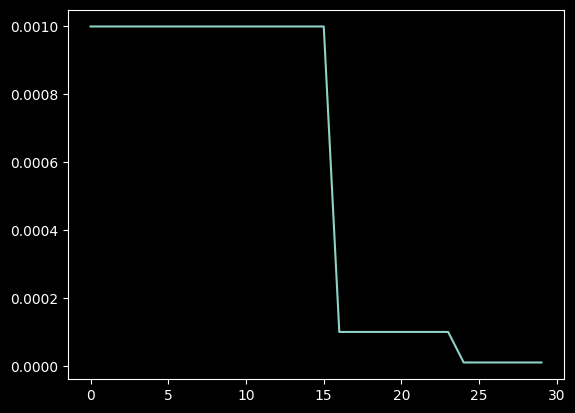

In [77]:
plt.plot(lr_list)
plt.show()

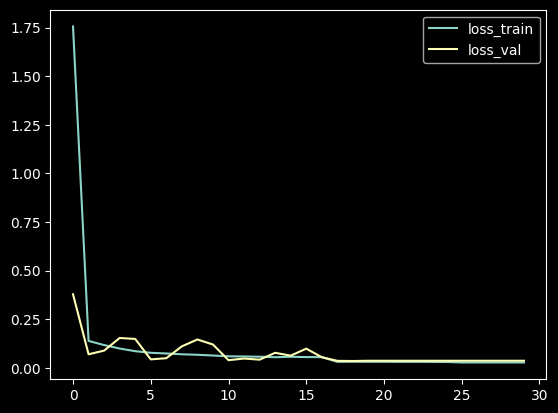

In [78]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()

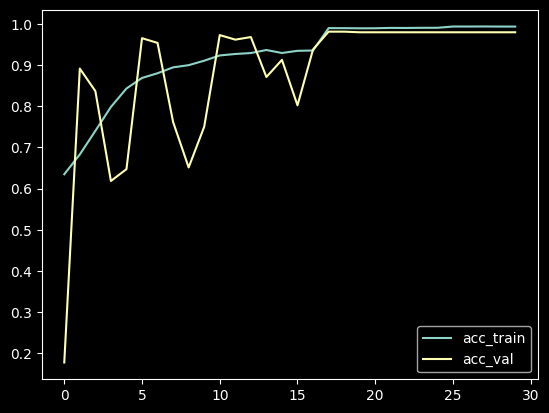

In [79]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['acc_train', 'acc_val'])
plt.show()

### Нюанс при восстановлении данных 'cpu' или 'cuda'

Допустим, мы обучали модель на графическом процессоре. Но теперь у нас нет возможности работать с ним.

То есть мы можем работать только с cpu.
Воспроизведем данную ситуацию.

In [82]:
device = 'cpu'
device

'cpu'

In [83]:
# Загрузка параметров модели
param_model = torch.load('model_state_dict_epoch_6.pt', map_location=device)
param_model

/tmp/ipykernel_9910/4176671990.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  param_model = torch.load('model_state_dict_epoch_6.pt', map_location=device)


OrderedDict([('layer_1.weight',
              tensor([[ 0.0240,  0.0192,  0.0182,  ...,  0.0087,  0.0230,  0.0262],
                      [ 0.0056, -0.0334, -0.0120,  ...,  0.0070, -0.0136, -0.0029],
                      [ 0.0145, -0.0094,  0.0012,  ...,  0.0116, -0.0091, -0.0081],
                      ...,
                      [ 0.0422,  0.0394,  0.0195,  ...,  0.0141,  0.0301,  0.0348],
                      [ 0.0382,  0.0199,  0.0279,  ...,  0.0282,  0.0250,  0.0335],
                      [-0.0038, -0.0188, -0.0107,  ..., -0.0056, -0.0300,  0.0001]])),
             ('layer_1.bias',
              tensor([-1.4907e-02,  7.9568e-03,  2.1328e-02, -1.1968e-02,  9.4071e-04,
                      -1.6254e-02,  1.9897e-02,  6.6543e-03, -1.2949e-02,  6.3609e-03,
                      -2.8500e-02, -9.8291e-03, -1.7069e-02, -3.4238e-03,  6.6955e-03,
                       1.4439e-02, -1.0026e-02, -1.2440e-02,  4.6242e-02, -8.8028e-03,
                       1.2374e-02,  1.0508e-03, -5.6698e

Теперь все тензоры не лежат на графическом процессоре